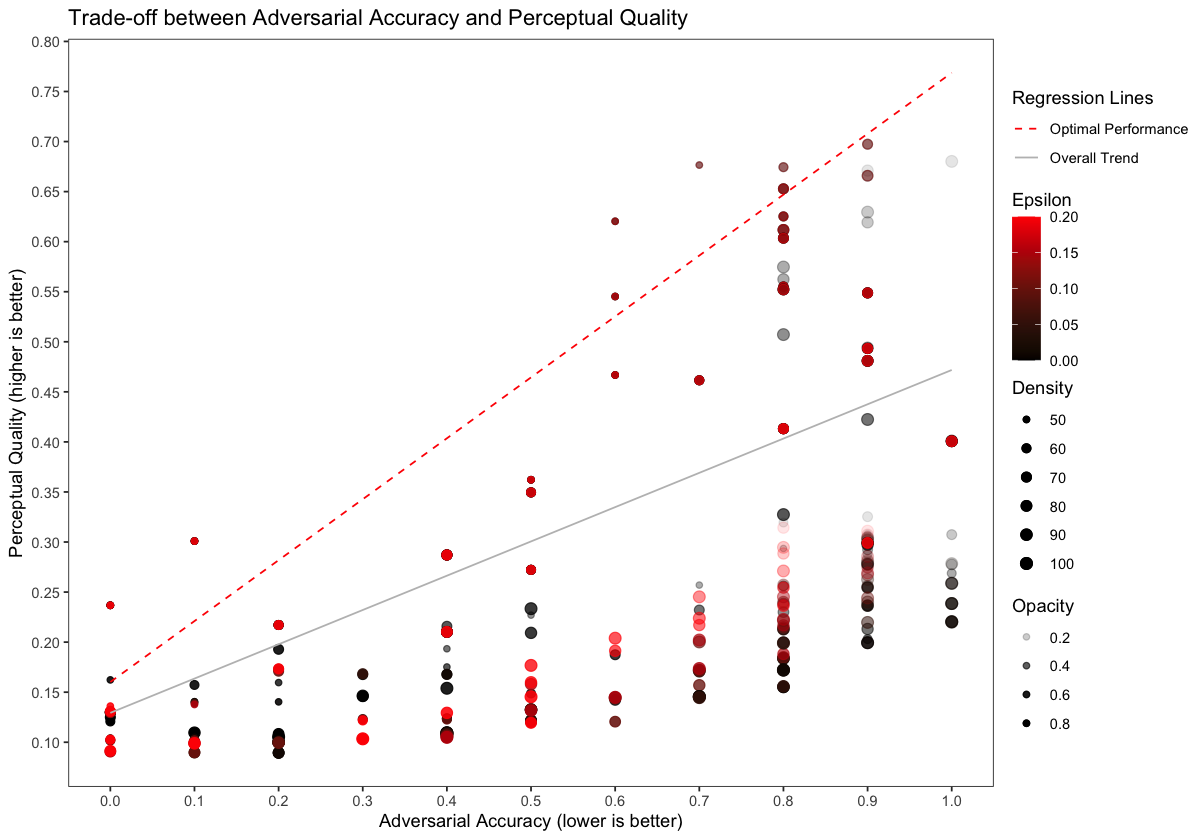

In [3]:
deps <- c("ISLR", "ndjson", "ggplot2", "dplyr", "caret", "tidyr", "gridExtra", "data.table", "repr", "modelr", "splines")
for (p in deps) {
    if (!requireNamespace(p, quietly = TRUE)) {
        install.packages(p, repos = "https://cran.rstudio.com")
    }
    library(p, character.only = TRUE)
}
options(scipen=999)
options(repr.plot.width=10, repr.plot.height=7)

path <- "./eval_cls_perturb.csv"
data <- data.frame(read.csv(path, header=TRUE, sep=","))

data <- data %>% 
    mutate(across(everything(), ~replace(., is.infinite(.), NA))) %>%
    na.omit() %>%
    distinct(opacity, density, perturb, epsilon, img_id, .keep_all = TRUE) %>%
    mutate(perturb = as.logical(perturb))

data <- data %>%
    mutate(
        adv_acc = ((advx_acc1 + advx_acc5) / 2) - ((x_acc1 + x_acc5) / 2) + 1,
        quality = (cosine_sim + psnr / 100 + ssim) / 3,
        final_score = -adv_acc + quality
    )

data <- data %>%
    group_by(opacity, density, perturb, epsilon) %>%
    summarise(
        adv_acc = mean(adv_acc),
        quality = mean(quality),
        final_score = mean(final_score),
        .groups = 'drop'
    ) %>%
    na.omit()

max_quality <- data %>%
    group_by(adv_acc) %>%
    slice_max(quality) %>%
    ungroup()

p <- ggplot(data, aes(x = adv_acc, y = quality)) +
    # perturb = FALSE
    geom_point(
        data = subset(data, !perturb),
        aes(size = density, alpha = opacity/255),
        color = "black"
    ) +
    # perturb = TRUE
    geom_point(
        data = subset(data, perturb),
        aes(size = density, alpha = opacity/255, color = epsilon),
    ) +
    # polynomial regression for max points
    geom_smooth(
        data = max_quality,
        aes(linetype = "Optimal Performance"),
        method = "lm",
        formula = y ~ poly(x, 1),
        color = "red",
        se = FALSE,
        size = 0.5
    ) +
    # overall polynomial regression
    geom_smooth(
        aes(linetype = "Overall Trend"),
        method = "lm",
        formula = y ~ poly(x, 1),
        color = "gray",
        se = FALSE,
        size = 0.5
    ) +
    # customize scales and theme
    scale_color_gradientn(
        colors = c("black", "red"),
        name = "Epsilon"
    ) +
    scale_size_continuous(
        name = "Density",
        range = c(1.5, 3)
    ) +
    scale_alpha_continuous(
        name = "Opacity"
    ) +
    labs(
        x = "Adversarial Accuracy (lower is better)",
        y = "Perceptual Quality (higher is better)",
        title = "Trade-off between Adversarial Accuracy and Perceptual Quality"
    ) +
    scale_linetype_manual(
        name = "Regression Lines",
        values = c("Overall Trend" = "solid", "Optimal Performance" = "dashed"),
        guide = guide_legend(order = 1)
    ) +
    theme(
        legend.position = "right",
    ) +
    scale_x_continuous(breaks = seq(0, 1, by = 0.1)) +
    scale_y_continuous(breaks = seq(0, 1, by = 0.05)) +
    theme_test()

print(p)
ggsave("./eval_cls_perturb.pdf", plot = p, device = "pdf", width = 10, height = 7, units = "in")